In [2]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt

import xcalendar as xcal
import flux_products

In [34]:
reload(grid_tools)
file_name = flux_products.files_res('GK01R','f09')
ds = xr.open_dataset(file_name)

file_name = flux_products.files_res('TAK09','f09')
ds = xr.merge((ds,xr.open_dataset(file_name).drop(['time','area'])))

file_name = 'data/f09_f09.nc'
grid = xr.open_dataset(file_name)
ds['lat'] = grid.lat
ds['lon'] = grid.lon
ds.time.values = np.array(['2002-%02d-15'%m for m in range(1,13)]).astype('datetime64[ns]')
ds

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 12)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * time      (time) datetime64[ns] 2002-01-15 2002-02-15 2002-03-15 ...
Data variables:
    area      (lat, lon) float32 ...
    O2_FLUX   (time, lat, lon) float32 ...
    CO2_FLUX  (time, lat, lon) float64 ...

In [35]:
ds.area.values = grid_tools.compute_grid_area(longitude=ds.lon.values,latitude=ds.lat.values)
ds

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 12)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * time      (time) datetime64[ns] 2002-01-15 2002-02-15 2002-03-15 ...
Data variables:
    area      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    O2_FLUX   (time, lat, lon) float32 ...
    CO2_FLUX  (time, lat, lon) float64 ...

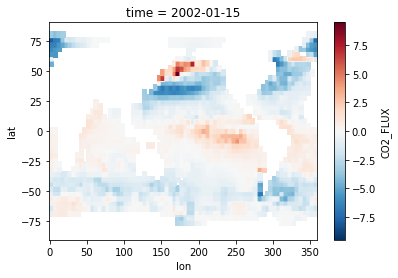

In [36]:
ds.CO2_FLUX.isel(time=0).plot()

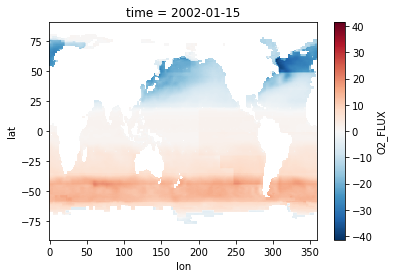

In [37]:
ds.O2_FLUX.isel(time=0).plot()

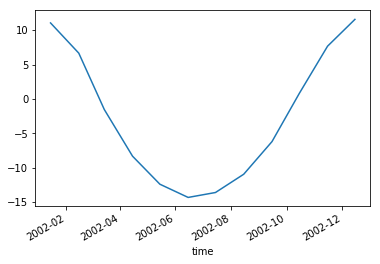

In [39]:
rmask = ds.O2_FLUX.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
o2 = (ds.O2_FLUX * wgt).sum(dim=['lon','lat'])
o2.attrs['long_name'] = 'O$_2$ flux'
o2.plot()

<xarray.DataArray (time: 12)>
array([-1.056414e+00, -1.157362e+00, -7.446797e-01, -6.638551e-01,
       -5.408479e-01, -3.081616e-01,  4.695706e-04,  3.416058e-01,
        4.341840e-01, -6.847216e-02, -4.266750e-01, -8.209997e-01])
Coordinates:
  * time     (time) datetime64[ns] 2002-01-15 2002-02-15 2002-03-15 ...
Attributes:
    long_name:  CO$_2$ flux

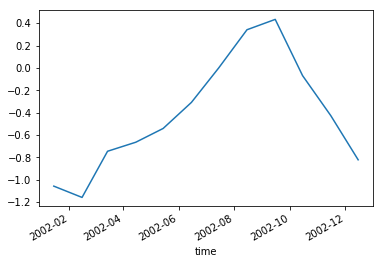

In [40]:
rmask = ds.CO2_FLUX.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
co2 = (ds.CO2_FLUX * wgt).sum(dim=['lon','lat'])
co2.attrs['long_name'] = 'CO$_2$ flux'
co2.plot()
co2

Text(0,0.5,u'O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

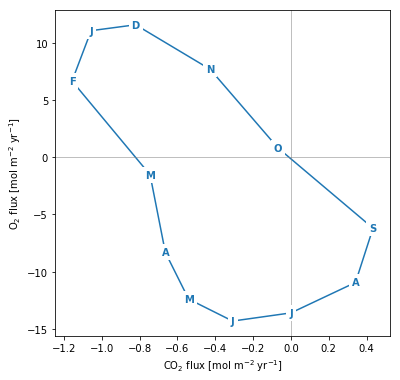

In [41]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(co2,o2,marker='o',facecolors='none',edgecolors='none')
p = ax.plot(xr.concat((co2,co2.isel(time=0,drop=False)),dim='time'),
            xr.concat((o2,o2.isel(time=0,drop=False)),dim='time'),'-')

for i in range(12):
    t = ax.text(co2[i],o2[i],xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.3',fc='white',ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
ax.set_ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

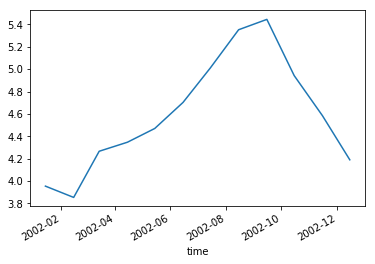

In [43]:
(co2-co2.sum()).plot()